In [12]:
from tensorflow.keras.utils import Sequence
from skimage import color
import os
import numpy as np
import cv2
import tensorflow as tf

class ColorizationDataGenerator(Sequence):
    """
    Custom data generator for colorization task.
    Loads RGB images from folders, converts to LAB, extracts channels.
    """
    def __init__(self, data_dir, target_size=(400, 400), batch_size=128, mode="train"):
        """
        Initializes the data generator.
        
        Args:
            data_dir: Path to the directory containing subfolders (train, val, test).
            target_size: Target size for resizing images.
            batch_size: Batch size for data generation.
            mode: "train", "val", or "test" indicating data split.
        """
        super().__init__()
        self.data_dir = data_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.mode = mode

        # Get list of image paths based on mode
        self.image_paths = self._get_image_paths(mode)
        self.num_images = len(self.image_paths)

    def _get_image_paths(self, mode):
        """
        Gets a list of image paths based on the specified mode (train, val, test).
        """
        image_paths = []
        for subfolder in ["train2017", "val2017", "test2017"]:  # Assuming subfolder structure
            if subfolder == mode:
                folder_path = os.path.join(self.data_dir, subfolder)
                for filename in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, filename)
                    image_paths.append(image_path)
        return image_paths[:10000]

    def __len__(self):
        """
        Returns the number of batches in the dataset for the specified mode.
        """
        return int(np.ceil(self.num_images / self.batch_size))

    def __getitem__(self, idx):
        """
        Generates a batch of data (L channel and ab channels) at the given index.
        """
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for image_path in batch_image_paths:
            # Load image (replace with your preferred library)
            image = cv2.imread(image_path)  # Example using OpenCV

            # Preprocess the image (e.g., resize, normalize, convert to LAB)
            image = cv2.resize(image, self.target_size)
            image = image.astype("float32") / 255.0  # Normalize pixel values

            lab_image = color.rgb2lab(image)
            L, ab = lab_image[..., 0], lab_image[..., 1:]
            L = L.reshape((self.target_size[0],self.target_size[1],1))

            X_batch.append(L)
            y_batch.append(ab)

        return np.array(X_batch), np.array(y_batch)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and hyperparameters
data_dir = "/kaggle/input/coco-2017-dataset/coco2017"  # Replace with your data directory path
target_size = (400, 400)
batch_size = 64

# Create data generators for training and validation (if applicable)
train_generator = ColorizationDataGenerator(data_dir, target_size, batch_size, mode="train2017")
# val_generator = ColorizationDataGenerator(data_dir, target_size, batch_size, mode="val2017")  # Example for validation set

def train_generator():
    return ColorizationDataGenerator(data_dir, target_size, batch_size, mode="train2017")

def val_generator():
    return ColorizationDataGenerator(data_dir, target_size, batch_size, mode="val2017")

# Create a dataset from the generator function
val_dataset = tf.data.Dataset.from_generator(
    generator=val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([None, target_size[0], target_size[1], 1]), tf.TensorShape([None, target_size[0], target_size[1], 2]))
)

train_dataset = tf.data.Dataset.from_generator(
    generator=train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([None, target_size[0], target_size[1], 1]), tf.TensorShape([None, target_size[0], target_size[1], 2]))
)

# Repeat the dataset indefinitely
val_dataset = val_dataset.repeat()
train_dataset = train_dataset.repeat()
# # Optionally, you can batch the dataset
# train_dataset = val_dataset.batch(batch_size)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def create_colorization_model():
  # Define the model layers
  inputs = keras.Input(shape=(None, None, 1))  # Grayscale image with 1 channel

  conv1 = layers.Conv2D(32, kernel_size=4, strides=2, padding="same")(inputs)
  conv1_bn = layers.BatchNormalization()(conv1)
  conv1_relu = layers.Activation("relu")(conv1_bn)

  conv2 = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(conv1_relu)
  conv2_bn = layers.BatchNormalization()(conv2)
  conv2_relu = layers.Activation("relu")(conv2_bn)

  conv3 = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(conv2_relu)
  conv3_bn = layers.BatchNormalization()(conv3)
  conv3_relu = layers.Activation("relu")(conv3_bn)

  conv4 = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(conv3_relu)
  conv4_bn = layers.BatchNormalization()(conv4)
  conv4_relu = layers.Activation("relu")(conv4_bn)

  # Dilation layers
  conv5 = layers.Conv2D(256, kernel_size=4, dilation_rate=2, padding="same")(conv4_relu)
  conv5_bn = layers.BatchNormalization()(conv5)
  conv5_relu = layers.Activation("relu")(conv5_bn)

  conv6 = layers.Conv2D(256, kernel_size=4, dilation_rate=2, padding="same")(conv5_relu)
  conv6_bn = layers.BatchNormalization()(conv6)
  conv6_relu = layers.Activation("relu")(conv6_bn)

  # Deconvolution layers with concatenation
  t_conv1 = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(conv6_relu)
  t_conv1_bn = layers.BatchNormalization()(t_conv1)
  t_conv1_relu = layers.Activation("relu")(t_conv1_bn)

  concat1 = layers.Concatenate(axis=-1)([t_conv1_relu, conv3_relu])

  t_conv2 = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(concat1)
  t_conv2_bn = layers.BatchNormalization()(t_conv2)
  t_conv2_relu = layers.Activation("relu")(t_conv2_bn)

  concat2 = layers.Concatenate(axis=-1)([t_conv2_relu, conv2_relu])

  t_conv3 = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")(concat2)
  t_conv3_bn = layers.BatchNormalization()(t_conv3)
  t_conv3_relu = layers.Activation("relu")(t_conv3_bn)

  concat3 = layers.Concatenate(axis=-1)([t_conv3_relu, conv1_relu])

  t_conv4 = layers.Conv2DTranspose(2, kernel_size=4, strides=2, padding="same")(concat3)

  concat4 = layers.Concatenate(axis=-1)([t_conv4, inputs])

  outputs = layers.Conv2D(2, kernel_size=3, padding="same")(concat4)

  # Create the Keras model
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model


model = create_colorization_model()
# model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, None,      │        544 │ input_layer_3[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │     32,832 │ activation_9[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, None,      │    131,200 │ activation_10[0]… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, None,      │    524,544 │ activation_11[0]… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, None,      │  1,048,832 │ activation_12[0]… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, None,      │  1,048,832 │ activation_13[0]

 Total params: 3,645,946 (13.91 MB)

 Trainable params: 3,643,514 (13.90 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [14]:
model.compile(optimizer='adam', loss='mae')
model.fit(val_dataset, epochs=100, steps_per_epoch=len(val_generator()))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 33.5394
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 10.4635
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 9.5266
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.4486
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.3582
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.2653
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.2043
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.1285
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 9.0818
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 9.0373
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 9.0004
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 8.9581
Epoch 13/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 8.9189
Epoch 14/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 8.9021
Epoch 15/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - 

In [1]:
from tensorflow.keras.utils import Sequence
from skimage import color
import os
import numpy as np
import cv2
import tensorflow as tf

class ColorizationDataGenerator(Sequence):
    """
    Custom data generator for colorization task.
    Loads RGB images from folders, converts to LAB, extracts channels.
    """
    def __init__(self, data_dir, target_size=(400, 400), batch_size=128, mode="train"):
        """
        Initializes the data generator.
        
        Args:
            data_dir: Path to the directory containing subfolders (train, val, test).
            target_size: Target size for resizing images.
            batch_size: Batch size for data generation.
            mode: "train", "val", or "test" indicating data split.
        """
        super().__init__()
        self.data_dir = data_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.mode = mode

        # Get list of image paths based on mode
        self.image_paths = self._get_image_paths(mode)
        self.num_images = len(self.image_paths)

    def _get_image_paths(self, mode):
        """
        Gets a list of image paths based on the specified mode (train, val, test).
        """
        image_paths = []
        for subfolder in ["train2017", "val2017", "test2017"]:  # Assuming subfolder structure
            if subfolder == mode:
                folder_path = os.path.join(self.data_dir, subfolder)
                for filename in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, filename)
                    image_paths.append(image_path)
        return image_paths[:10000]

    def __len__(self):
        """
        Returns the number of batches in the dataset for the specified mode.
        """
        return int(np.ceil(self.num_images / self.batch_size))

    def __getitem__(self, idx):
        """
        Generates a batch of data (L channel and ab channels) at the given index.
        """
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for image_path in batch_image_paths:
            # Load image (replace with your preferred library)
            image = cv2.imread(image_path)  # Example using OpenCV

            # Preprocess the image (e.g., resize, normalize, convert to LAB)
            image = cv2.resize(image, self.target_size)
            image = image.astype("float32") / 255.0  # Normalize pixel values

            lab_image = color.rgb2lab(image)
            L, ab = lab_image[..., 0], lab_image[..., 1:]
            # Create the L channel image
            
            L = color.gray2rgb(L)
            L = L.reshape((target_size[0],target_size[1], 3))
            
#             print(L.shape,ab.shape)
            X_batch.append(L)
            y_batch.append(ab)

        return np.array(X_batch), np.array(y_batch)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and hyperparameters
data_dir = "/kaggle/input/coco-2017-dataset/coco2017"  # Replace with your data directory path
target_size = (400, 400)
batch_size = 32

# Create data generators for training and validation (if applicable)
# train_generator = ColorizationDataGenerator(data_dir, target_size, batch_size, mode="train2017")
# val_generator = ColorizationDataGenerator(data_dir, target_size, batch_size, mode="val2017")  # Example for validation set

def train_generator():
    return ColorizationDataGenerator(data_dir, target_size, batch_size, mode="train2017")

def val_generator():
    return ColorizationDataGenerator(data_dir, target_size, batch_size, mode="val2017")

# Create a dataset from the generator function
val_dataset = tf.data.Dataset.from_generator(
    generator=val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([None, target_size[0], target_size[1], 3]), tf.TensorShape([None, target_size[0], target_size[1], 2]))
)

train_dataset = tf.data.Dataset.from_generator(
    generator=train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([None, target_size[0], target_size[1], 3]), tf.TensorShape([None, target_size[0], target_size[1], 2]))
)

# Repeat the dataset indefinitely
val_dataset = val_dataset.repeat()
train_dataset = train_dataset.repeat()
# # Optionally, you can batch the dataset
# train_dataset = val_dataset.batch(batch_size)


2024-05-16 10:11:17.819464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 10:11:17.819572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 10:11:18.070515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16  # Or any other pre-trained model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def create_colorization_model(pretrained_model_name="VGG16"):
  """
  Creates a colorization model using transfer learning with improvements.

  Args:
      pretrained_model_name: Name of the pre-trained model to use (e.g., VGG16).

  Returns:
      A compiled Keras model for colorization.
  """

  # Load the pre-trained model with pre-trained weights.
  pretrained_model = VGG16(weights="imagenet", include_top=False)  # Use "imagenet" for pre-trained weights
  pretrained_model.trainable = False  # Freeze pre-trained model layers

  # Create our colorization model on top of the pre-trained model
  inputs = pretrained_model.input

  # Use the outputs from a specific layer in the pre-trained model (experiment for best layer)
  outputs = pretrained_model.layers[-2].output  # Example: Take output from the second-last layer

  x = Conv2D(256, (3, 3), activation='relu', padding='same')(outputs)
  x = BatchNormalization()(x)  # Add Batch Normalization after each convolutional layer

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D((2, 2))(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D((2, 2))(x)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D((2, 2))(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)

  x = UpSampling2D((2, 2))(x)

  # Use Leaky ReLU for the final layer (better for color output)
  x = Conv2D(2, (3, 3), padding='same')(x)

  outputs = LeakyReLU(negative_slope=0.2)(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

# Example usage remains the same


# Example usage: assuming you have your colorization dataset loaded as (X_train, y_train)
model = create_colorization_model()

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 16,288,786 (62.14 MB)

 Trainable params: 1,573,106 (6.00 MB)

 Non-trainable params: 14,715,680 (56.14 MB)

In [ ]:
model.compile(optimizer='adam', loss=ssim_loss)
model.fit(val_dataset, epochs=100, steps_per_epoch=len(val_generator()))

In [ ]:
# After training your model
model.save_weights("colorization_vgg.weights.h5")

# After training your model
model.save("colorization_model_vgg.h5")

In [76]:
# Define the path to your saved model file
# model_path = "/kaggle/input/colorization-model/colorization_model.h5"
model_path = "colorization_model.h5"
# Load the model
model = tf.keras.models.load_model(model_path)

(400, 400)
(1, 400, 400, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


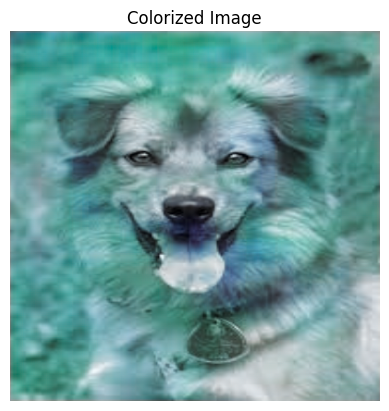

In [16]:
import cv2
from skimage import color
import matplotlib.pyplot as plt
import numpy as np

target_size = (400, 400)  # Assuming this matches your model's input size

def predict_colorized_image(image_path):

    # Load the image
    image = cv2.imread(image_path)

    # Preprocess the image
    image = cv2.resize(image, target_size)
    
    image = image.astype("float32") / 255.0

    lab_image = color.rgb2lab(image)
    L_channel = lab_image[..., 0]
    print(L_channel.shape)
    # Prepare image for prediction (batch format)
    
    L_channel = np.expand_dims(L_channel, axis=-1)
    L_channel = np.expand_dims(L_channel, axis=0)

    # Predict ab channels
    print(L_channel.shape)
    predicted_ab = model.predict(L_channel)
    # After prediction
#     predicted_ab = np.clip(predicted_ab, 0, 255)  # Clamp predicted channels between 0 and 255

    # Post-process the prediction
    predicted_ab = predicted_ab.squeeze(axis=0)
#     predicted_ab = np.clip(predicted_ab, 0, 255)# Remove batch dimension from predicted_ab
    predicted_lab = np.concatenate([L_channel.squeeze(axis=0), predicted_ab], axis=2)
    colorized_image = color.lab2rgb(predicted_lab)  # Remove batch dimension

    return colorized_image

# Example usage (replace with your image path)
new_image_path = "/kaggle/input/mido-img/WhatsApp Image 2024-05-06 at 21.41.49_5a16d422.jpg"
colorized_image = predict_colorized_image(new_image_path)

# Display the colorized image using Matplotlib
plt.imshow(colorized_image)
plt.title("Colorized Image")
plt.axis("off")  # Hide axes for cleaner visualization (optional)
plt.show()
